This post presents two iterative methods for finding the minimum distance between a point and ellipse. The first method (Method 1) uses gradient descent to optimize the square distance formula between the point and a point on the ellipse. Meanwhile, the second method (Method 2) uses Newton's method to find the minima using the square distance formula's derivative.

![Ellipse-Point Diagram](https://user-images.githubusercontent.com/23442063/141510244-1220675b-17c5-44a2-ac27-da1265db4f5a.png)

**Figure 1: Ellipse and Point Geometry**

<!--excerpt-->

### Equation Development

The ellipse and point geometry is shown in Figure 1. Finding a solution is made simpler by shifting and rotating the coordinate system so that the ellipse is centered at (0, 0) and its major and minor axes are in line with the x and y axes. Performing these operations, the resulting ellipse coordinate, $ x_1 $, and point coordinate, $ x_2 $, are

$$ x_1 = (a \cos t, b \sin t) $$

$$ x_2 = r^T (x - x_0) $$

For an ellipse rotated counter-clockwise by angle $ \phi $, the [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix) is

$$
r =
\begin{bmatrix}
\cos \phi & -\sin \phi \\
\sin \phi & \cos \phi
\end{bmatrix}
$$

To find the minimum distance, we can optimize the square distance between the ellipse and point coordinates:

$$ D^2 = (x_1 - x_2) \cdot (x_1 - x_2) $$

Two iterative methods, gradient descent and Newton's method, will be used to optimize this function. The derivatives of the square distance function required for these method are shown below. Details for the implementation of the optimization methods using these functions are presented in the sections to follow.

$$ \frac{d D^2}{d t} = 2 \frac{d x_1}{d t} \cdot (x_1 - x_2) $$

$$ \frac{d D^2}{d t^2} = 2 \frac{d x_1}{d t^2} \cdot (x_1 - x_2) + 2 \frac{d x_1}{d t} \cdot \frac{d x_1}{d t} $$

$$ \frac{d x_1}{d t} = (-a \sin t, b \cos t) $$

$$ \frac{d x_1}{d t^2} = (-a \cos t, -b \sin t) $$

#### Method 1: Gradient Descent

For the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) method, iterations on $ t $ may be taken as:

$$ t_{n+1} = t_n - \alpha \frac{d D^2}{d t}$$

A reasonable starting value for the algorithm is simply the angle to the point coordinate:

$$ t_0 = \text{atan2}\bigg(\frac{y_2}{x_2}\bigg) $$

#### Method 2: Newton's Method

For [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), iterations on $ t $ may be taken as:

$$ t_{n+1} = t_n - \frac{\frac{d D^2}{d t}}{\frac{d D^2}{d t^2}} $$

For points located outside of the ellipse, a reasonable starting value is the same as that of the gradient descent method. For points inside of the ellipse, however, this value is not adequate to prevent the solution from converging to a maxima or other local solution. Generating polygon vertices around the ellipse and using the angle corresponding to the minimum distance between the point coordinate and vertices resolves this issue, though this solution may be somewhat ineligant.

### Import Statements

The following imports the Python packages that will be used for implementing the algorithms. This post uses the `numpy` package for array operations and `matplotlib` package for plotting results.

In [1]:
%matplotlib notebook
import math
import numpy as np
import matplotlib.pyplot as plt

### Ellipse Class Implementation

An ellipse class implementing the gradient descent and Newton's method functions as `find_distance1` and `find_distance2`, respectively, is shown below.

In [2]:
class Ellipse:
    def __init__(self, x, y, width, height, angle = 0):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.angle = angle
        
    def rotation_matrix(self):
        """
        Returns the rotation matrix for the ellipse's rotation.
        """
        a = math.cos(self.angle)
        b = math.sin(self.angle)
        return np.array([[a, -b], [b, a]])
    
    def get_point(self, angle):
        """
        Returns the point on the ellipse at the specified local angle.
        """
        r = self.rotation_matrix()
        xe = 0.5 * self.width * math.cos(angle)
        ye = 0.5 * self.height * math.sin(angle)
        return np.dot(r, [xe, ye]) + [self.x, self.y]
    
    def get_points(self, count):
        """
        Returns an array of points around the ellipse in the specified count.
        """
        t = np.linspace(0, 2 * math.pi, count)
        xe = 0.5 * self.width * np.cos(t)
        ye = 0.5 * self.height * np.sin(t)
        r = self.rotation_matrix()
        return np.dot(np.column_stack([xe, ye]), r.T) + [self.x, self.y]
    
    def find_distance1(self, x, tolerance = 1e-8, max_iterations = 10000, learning_rate = 0.01):
        """
        Finds the minimum distance between the specified point and the ellipse
        using gradient descent.
        """
        x = np.asarray(x)
        r = self.rotation_matrix()
        x2 = np.dot(r.T, x - [self.x, self.y])
        t = math.atan2(x2[1], x2[0])
        a = 0.5 * self.width
        b = 0.5 * self.height
        iterations = 0
        error = tolerance
        errors = []
        ts = []
        
        while error >= tolerance and iterations < max_iterations:
            cost = math.cos(t)
            sint = math.sin(t)
            x1 = np.array([a * cost, b * sint])
            xp = np.array([-a * sint, b * cost])
            dp = 2 * np.dot(xp, x1 - x2)
            t -= dp * learning_rate
            error = abs(dp)
            errors.append(error)
            ts.append(t)
            iterations += 1
            
        ts = np.array(ts)
        errors = np.array(errors)
        y = np.linalg.norm(x1 - x2)
        success = error < tolerance and iterations < max_iterations
        return dict(x = t, y = y, error = error, iterations = iterations, success = success, xs = ts,  errors = errors)
    
    def find_distance2(self, x, tolerance = 1e-8, max_iterations = 1000):
        """
        Finds the minimum distance between the specified point and the ellipse
        using Newton's method.
        """
        x = np.asarray(x)
        r = self.rotation_matrix()
        x2 = np.dot(r.T, x - [self.x, self.y])
        t = math.atan2(x2[1], x2[0])
        a = 0.5 * self.width
        b = 0.5 * self.height
        
        # If point is inside ellipse, generate better initial angle based on vertices
        if (x2[0] / a)**2 + (x2[1] / b)**2 < 1:
            ts = np.linspace(0, 2 * math.pi, 24, endpoint = False)
            xe = a * np.cos(ts)
            ye = b * np.sin(ts)
            delta = x2 - np.column_stack([xe, ye])
            t = ts[np.argmin(np.linalg.norm(delta, axis = 1))]
            
        iterations = 0
        error = tolerance
        errors = []
        ts = []
                
        while error >= tolerance and iterations < max_iterations:
            cost = math.cos(t)
            sint = math.sin(t)
            x1 = np.array([a * cost, b * sint])
            xp = np.array([-a * sint, b * cost])
            xpp = np.array([-a * cost, -b * sint])
            delta = x1 - x2
            dp = np.dot(xp, delta)
            dpp = np.dot(xpp, delta) + np.dot(xp, xp)
            t -= dp / dpp
            error = abs(dp / dpp)
            errors.append(error)
            ts.append(t)
            iterations += 1
        
        ts = np.array(ts)
        errors = np.array(errors)
        y = np.linalg.norm(x1 - x2)
        success = error < tolerance and iterations < max_iterations
        return dict(x = t, y = y, error = error, iterations = iterations, success = success, xs = ts,  errors = errors)

### Evaluation of Methods

In order to evaluate the methods, the following generates random points and then uses the `find_distance` methods to produce solutions for the minimum distance between the ellipse and the points. As shown, both methods successfully converge to solutions for all point and yield similar distance results.

In [3]:
# Generate random points
size = 6
np.random.seed(12345)
points = np.random.rand(500, 2)
points = size * points - size * (1 - points)
points = np.append(points, [[0, 0]], axis = 0)

# Ellipse definition
ellipse = Ellipse(0, 0, 6, 10, np.deg2rad(15))

# Verify that iterations were successful
solutions1 = [ellipse.find_distance1(x) for x in points]
print(f"Method 1 Solutions Successful: {np.all([x['success'] for x in solutions1])}")

solutions2 = [ellipse.find_distance2(x) for x in points]
print(f"Method 2 Solutions Successful: {np.all([x['success'] for x in solutions2])}")

allclose = np.allclose([x["y"] for x in solutions1], [x["y"] for x in solutions2])
print(f"Methods Yield Similar Results: {allclose}")

Method 1 Solutions Successful: True
Method 2 Solutions Successful: True
Methods Yield Similar Results: True


#### Method Time Benchmarks

The following code presents time benchmarks for the two methods. From these results, Method 2 (Newton's method) is nearly 3 times faster than Method 1 (gradient descent).

##### Method 1: Gradient Descent

In [4]:
%%timeit
for x in points:
    ellipse.find_distance1(x)

367 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Method 2: Newton's Method

In [5]:
%%timeit
for x in points:
    ellipse.find_distance2(x)

111 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Method Convergence

Plots of the method convergences are shown below. As seen in the plots, Method 1 (gradient descent) converges very slowly, exceeding 100 iterations for many solutions. On the other hand, Method 1 (Newton's method) converges rapidly, with a maximum of 4 iterations. This difference in efficiency is an obvious eplaination of the time differences between the algorithms, seen in the previous section.

In addition, the gradient descent method does not show constant decreases in error across all solutions, but rather some samples show increases, perhaps due to overshooting solutions or due to poor initial values.

<IPython.core.display.Javascript object>


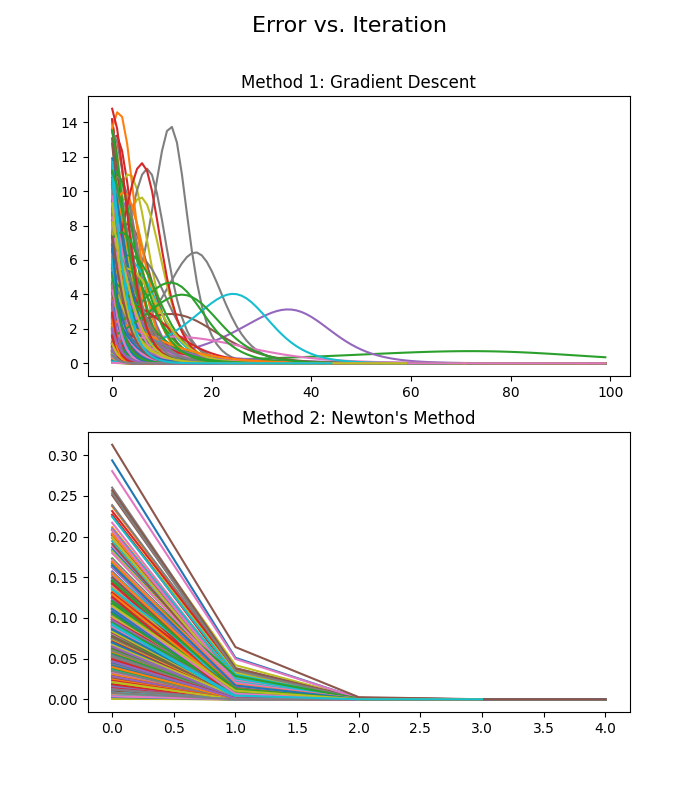

In [6]:
fig = plt.figure(figsize=(7, 8))
fig.suptitle("Error vs. Iteration", fontsize = 16)

# Method 1 plot
ax = fig.add_subplot(211, title = "Method 1: Gradient Descent")

for solution in solutions1:
    x = solution["errors"]
    ax.plot(np.arange(len(x))[:100], x[:100], "-")
    
# Method 2 plot
ax = fig.add_subplot(212, title = "Method 2: Newton's Method")

for solution in solutions2:
    x = solution["errors"]
    ax.plot(np.arange(len(x))[:100], x[:100], "-")

#### Visual Verification

The following plots the results of the methods for visual verification. For both methods, the identified closest points appear to be perpendicular to the ellipse and seem to reflect the minimum distances.

<IPython.core.display.Javascript object>


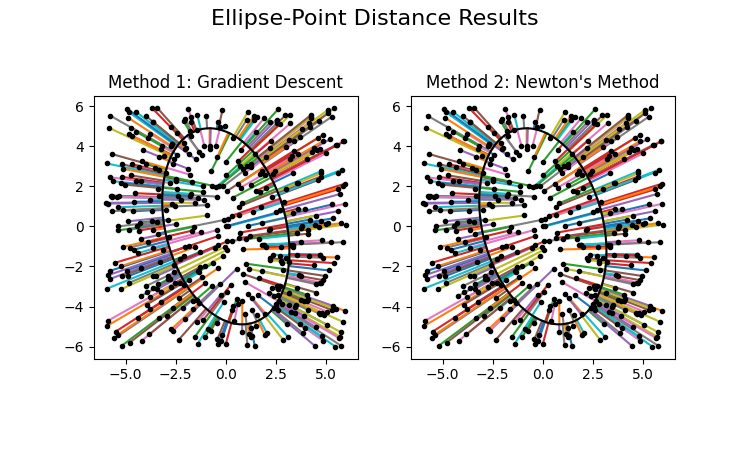

In [7]:
fig = plt.figure(figsize=(7.5, 4.5))
fig.suptitle("Ellipse-Point Distance Results", fontsize = 16)

# Generate ellipse points
ellipse_points = ellipse.get_points(100)

# Method 1 Plot
ax = fig.add_subplot(121, title = "Method 1: Gradient Descent", aspect = "equal")

for solution, point in zip(solutions1, points):
    x = np.array([ellipse.get_point(solution["x"]), point])
    ax.plot(x[:,0], x[:,1])

ax.plot(points[:,0], points[:,1], "k.")
ax.plot(ellipse_points[:,0], ellipse_points[:,1], "k-")

# Method 2 Plot
ax = fig.add_subplot(122, title = "Method 2: Newton's Method", aspect = "equal")

for solution, point in zip(solutions2, points):
    x = np.array([ellipse.get_point(solution["x"]), point])
    ax.plot(x[:,0], x[:,1])
    
ax.plot(points[:,0], points[:,1], "k.")
ax.plot(ellipse_points[:,0], ellipse_points[:,1], "k-");

### Conclusions

From the above results, the following conclusions can be drawn:

* Both Method 1 (gradient descent) and Method 2 (Newton's method) produce essentially the same minimum distance results for the problem.
* Method 2 (Newton's method) is nearly 3 times faster than Method 1 (gradient descent), in part because it is a quadratic algorithm vs. a linear.
* Method 2 (Newton's method) is much more sensitive to to the initial value used for iteration for points located within the ellipse. This was adjusted for using ellipse polygon vertices to acquire a better initial condition. However, depending on the eccentricity of the ellipse, the number of vertices used may not be 100% dependable for converging to the correct solution. Therefore, for points located inside the ellipse, Method 1 (gradient descent), may be a better fallback, though it takes more time to compute.